IMPORT & CLEAN UP

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("data\\2m_292_crop.csv", header=None)


x_pixel, y_pixel = 570, 570
fps = 100
bodyparts = ['snout', 'mouth', 'paw_VL','paw_VR', 'middle', 'paw_HL', 'paw_HR','anus', 'tail_start', 'tail_middle', 'tail_end']
center_bodyparts = ['snout', 'mouth', 'paw_VL','paw_VR', 'middle', 'paw_HL', 'paw_HR','anus']
paws_pos = ['pos', 'paw_VL', 'paw_VR', 'paw_HL', 'paw_HR']
paws = ['paw_VL', 'paw_VR', 'paw_HL', 'paw_HR']
paws_coor = ['paw_VL_x', 'paw_VL_y', 'paw_VR_x', 'paw_VR_y', 'paw_HL_x', 'paw_HL_y', 'paw_HR_x', 'paw_HR_y']
colors = ['r', 'b', 'g', 'm']


# combines the string of the two rows to create new header
new_columns = [f"{col[0]}_{col[1]}" for col in zip(df.iloc[1], df.iloc[2])]     # df.iloc[0] takes all values of first row
df.columns = new_columns
df = df.drop(labels=[0, 1, 2], axis="index")

# adapt index
df.set_index('bodyparts_coords', inplace=True)
df.index.names = ['frames']

# turn all the prior string values into floats and index into int
df = df.astype(float)
df.index = df.index.astype(int)

# flip the video along the x axis
for column in df.columns:
    if '_y' in column:
        df[column] = y_pixel - df[column] 

# whereever _likelihood <= x, change _x & _y to nan
for bodypart in bodyparts:
    filter = df[f'{bodypart}_likelihood'] <= 0.9
    df.loc[filter, f'{bodypart}_x'] = np.nan
    df.loc[filter, f'{bodypart}_y'] = np.nan
    df = df.drop(labels=f'{bodypart}_likelihood', axis="columns")

# print(df)

In [2]:
# you have a series with True/False in each row (depending on filter condition) and you return the start& stop frame of the [True onset, True offset]
def true_on_off_set(filter_cond, min_frame_nb):
    timestamps = []
    start_idx = None
    prev_idx = None

    for idx, val in filter_cond.items():
        if val and start_idx is None:
            start_idx = idx
        
        elif not val and (start_idx is not None):
            if idx - start_idx >= min_frame_nb:
                timestamps.append([start_idx, prev_idx])
            start_idx = None
        prev_idx = idx

    if start_idx is not None:
        if filter_cond.index[-1] - start_idx >= min_frame_nb:
            timestamps.append([start_idx, filter_cond.index[-1]])
    
    return timestamps

GET CATWALKS

[[160, 270], [5980, 6090], [6570, 6670], [9010, 9170], [9500, 9600]]


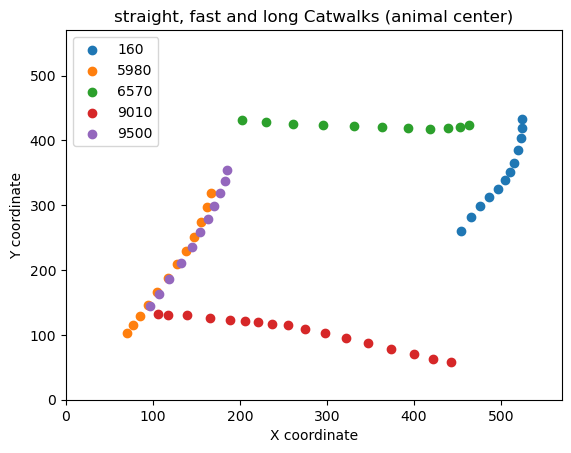

In [3]:
df_crop = df.iloc[::10]      # only includes every kth row to reduce noise
min_vector_lengh = 10
max_angle_diff = 0.15
min_catwalk_length = 100


# get stable position of the animal
def animal_position(df):
    # choose bodyparts that are always tracked and take the mean of them per row to have a stable animal position time series
    position_columns_x = ['middle_x', 'paw_HL_x', 'paw_HR_x','anus_x', 'tail_start_x']
    position_columns_y = ['middle_y', 'paw_HL_y', 'paw_HR_y','anus_y', 'tail_start_y']
    row_means_x = df[position_columns_x].mean(axis="columns")
    row_means_y = df[position_columns_y].mean(axis="columns")

    # create new data frame with animal position
    pos_df = pd.DataFrame(data={'pos_x': row_means_x, 'pos_y':row_means_y})
    pos_df = pos_df.rolling(window=10, win_type='gaussian', min_periods=1, center=True).mean(std=1)     # add a gaussian filter over the time series to reduce outlayers

    return pos_df

pos_df = animal_position(df_crop)

# get frames, where the animal is moving straight
def catwalk(pos_df):
    # calculate the difference between the k frame and the k-x frame
    changes = pos_df.diff(periods=1, axis='rows')

    # checks at which frames the vector magnitude is above x
    vector_lengths = np.sqrt(changes['pos_x']**2 + changes['pos_y']**2)
    does_move = vector_lengths >= min_vector_lengh

    # checks at which frames, the angle difference is below x
    angles = np.arctan2(changes['pos_x'], changes['pos_y'])     # angle between the vector (0,0) to (1,0) and the vector (0,0) to (x2,y2)
    angle_diff = abs(angles.diff(periods=1))
    does_straight = angle_diff <= max_angle_diff

    # combine both True/False series
    catwalk_filter = does_move & does_straight
    

    # get True on- and offset
    catwalk_timestamps = true_on_off_set(catwalk_filter, min_catwalk_length)

    return catwalk_timestamps

catwalk_timestamps = catwalk(pos_df)
print(catwalk_timestamps)

# add the pos_df to the main df
pos_df = pos_df.reindex(df.index)
df = df.join(pos_df)


for start, end in catwalk_timestamps:
    rows2plot = df.loc[start:end]
    plt.scatter(rows2plot['pos_x'], rows2plot['pos_y'], label=start)
plt.xlim(0, x_pixel)
plt.ylim(0, y_pixel)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.title('straight, fast and long Catwalks (animal center)')

plt.show()

GET STATIC FEET COORDINATES

C:\Users\landgrafn\AppData\Local\Temp\ipykernel_14680\820866015.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feet_df.loc[mask, [x, y]] = np.nan
C:\Users\landgrafn\AppData\Local\Temp\ipykernel_14680\820866015.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feet_df.loc[start:end, x] = step_mean
C:\Users\landgrafn\AppData\Local\Temp\ipykernel_14680\820866015.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feet_df.loc[sta

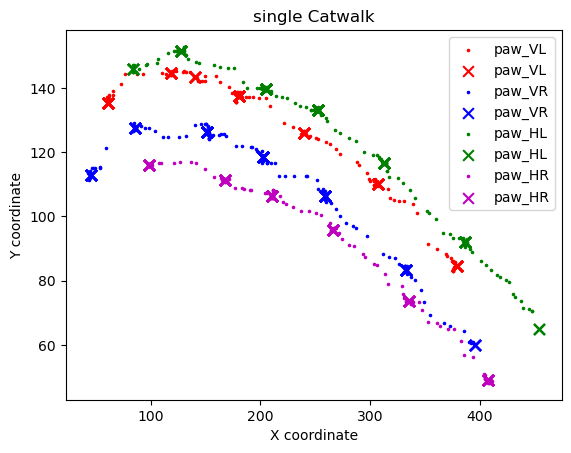

In [4]:
min_paw_movement = 5
min_static_frame_nb = 5

# get timestamps where paws are static and df with only the mean paw position, rest is nan
def calm_feet(df):
    # calculate the difference between the k frame and the k-x frame
    feet_df = df[paws_coor]
    feet_diff = abs(feet_df.diff(periods=1, axis='rows'))

    for paw in paws:
        x, y = f'{paw}_x', f'{paw}_y'
        
        # checks at which frames the vector magnitude is below x
        vector_lengths = np.sqrt(feet_diff[x]**2 + feet_diff[y]**2)
        paw_static = vector_lengths <= min_paw_movement
        static_paw_timestamps = true_on_off_set(paw_static, min_static_frame_nb)
    

        # creating a mask to change all values outside of timestamp-rows to nan, so that only static paw values exist
        mask = np.ones(len(feet_df), dtype=bool)
        for start, end in static_paw_timestamps:
            mask[start:end] = False
        feet_df.loc[mask, [x, y]] = np.nan


        # go through timestamps and change all values in this timestamp to the mean values of the timestamp
        for start, end in static_paw_timestamps:
            step_mean = feet_df.loc[start:end, x].mean()
            feet_df.loc[start:end, x] = step_mean
            step_mean = feet_df.loc[start:end, y].mean()
            feet_df.loc[start:end, y] = step_mean

    return static_paw_timestamps, feet_df

static_paw_timestamps, feet_df = calm_feet(df)


# plot static feet in certain catwalk_timestamp
rows2plot_raw = df.loc[catwalk_timestamps[3][0] : catwalk_timestamps[3][1]]
rows2plot_mean = feet_df.loc[catwalk_timestamps[3][0] : catwalk_timestamps[3][1]]
for i, paw in enumerate(paws):
    plt.scatter(rows2plot_raw[f'{paw}_x'], rows2plot_raw[f'{paw}_y'], label=paw, c=colors[i], marker='.', s=10)
    plt.scatter(rows2plot_mean[f'{paw}_x'], rows2plot_mean[f'{paw}_y'], label=paw, c=colors[i], marker='x', s=60)

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.title('single Catwalk')

plt.show()

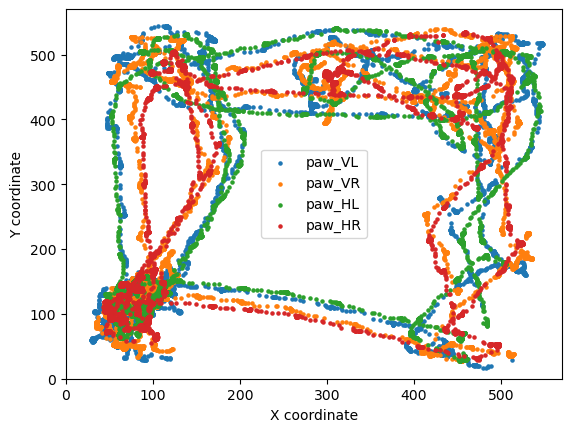

In [5]:
for part in paws:
    plt.scatter(df[f'{part}_x'], df[f'{part}_y'], s=5, label=part)
    
plt.xlim(0, x_pixel)
plt.ylim(0, y_pixel)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()

plt.show()